In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import lightgbm as lgb
import xgboost as xgb

In [60]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/EyeTracking/dataset/synthetic_behavior_dataset_50000.csv")

In [33]:
df

,Question ID,Fixation Duration,Saccade Speed,Blink Rate,Label,Number of Fixations,Avg. Fixation Duration,Number of Saccades,Saccade Amplitude,Avg. Saccade Amplitude,Avg. Pupil Size (L),Avg. Pupil Size (R)
0,Q1,5.73,0.29,10,Confused,16,0.36,13,1.29,0.10,2.14,3.74
1,Q2,5.76,0.30,10,Confused,17,0.34,15,1.95,0.13,2.77,3.13
2,Q3,3.03,0.22,1,Confident,13,0.23,5,0.65,0.13,2.82,4.37
3,Q4,2.33,0.20,8,Unknown,12,0.19,9,1.04,0.12,4.00,4.33
4,Q5,5.98,0.26,6,Confident,17,0.35,14,1.65,0.12,3.67,2.04
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Q496,3.01,0.27,2,Confident,17,0.18,11,1.74,0.16,3.08,4.06
496,Q497,3.86,0.20,8,Confused,19,0.20,8,1.30,0.16,2.64,2.27
497,Q498,4.66,0.26,4,Confident,10,0.47,15,1.93,0.13,2.18,4.32
498,Q499,5.38,0.30,1,Confident,12,0.45,12,1.44,0.12,2.12,3.41


In [35]:
# df.drop(columns=['Question ID'], inplace=True)

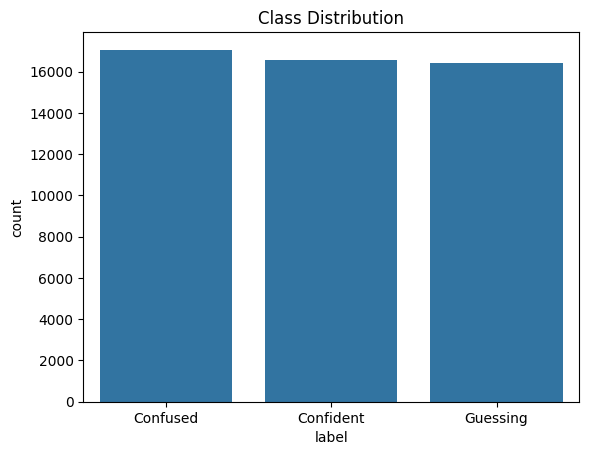

In [61]:
sns.countplot(data=df, x='label')
plt.title("Class Distribution")
plt.show()

X = df.drop("label", axis=1)
y = df["label"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [62]:
# using label encoding convert the categorical data into numerical
from sklearn.preprocessing import LabelEncoder
# Create and fit the encoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [63]:
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)

print("LGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2070
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 10
[LightGBM] [Info] Start training from score -1.106392
[LightGBM] [Info] Start training from score -1.075433
[LightGBM] [Info] Start training from score -1.114437
LGBM Classification Report:
              precision    recall  f1-score   support

   Confident       0.99      0.99      0.99      3307
    Confused       0.98      0.97      0.97      3412
    Guessing       0.98      0.98      0.98      3281

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [64]:
from sklearn.metrics import accuracy_score

# Calculate test accuracy for LightGBM
test_accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"Test Accuracy (LGBM): {test_accuracy_lgb:.4f}")


Test Accuracy (LGBM): 0.9814


In [65]:
# Before fitting the model, encode the target variable:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)  # Encode y_train
y_test_encoded = encoder.transform(y_test)  # Encode y_test using the same encoder

# Now fit the model using the encoded labels:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)  # Use encoded y_train

# Make predictions using the encoded test data:
y_pred_xgb = xgb_model.predict(X_test)

# For printing the classification report, you'll need to decode the predictions:
y_pred_decoded = encoder.inverse_transform(y_pred_xgb)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_decoded)) # Use decoded predictions

XGBoost Classification Report:
              precision    recall  f1-score   support

   Confident       0.99      0.99      0.99      3307
    Confused       0.98      0.97      0.97      3412
    Guessing       0.98      0.98      0.98      3281

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [66]:
from sklearn.metrics import accuracy_score

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_decoded)
print(f"Test Accuracy of XGBoost: {test_accuracy:.4f}")


Test Accuracy of XGBoost: 0.9817


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize and fit the model
simple_model = LogisticRegression()
simple_model.fit(X_train, y_train)  # Fit the model to your training data

# Predict on test set
y_pred_simple = simple_model.predict(X_test)  # Use X_test for predictions

# Calculate accuracy
test_accuracy_simple = accuracy_score(y_test, y_pred_simple)
print(f"Simple Logistic Regression Test Accuracy: {test_accuracy_simple:.4f}")

Simple Logistic Regression Test Accuracy: 0.9747


In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=5)  # 5-fold
print("CV Scores:", scores)
print("Average CV Accuracy:", scores.mean())

CV Scores: [0.9814 0.9804 0.9809 0.9825 0.9833]
Average CV Accuracy: 0.9817


In [69]:
#Train and test random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Train accuracy
y_train_pred = rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_acc:.4f}")

# Test accuracy
y_test_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Cross-validation accuracy
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"CV Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")

# Check for overfitting
if train_acc - test_acc > 0.1:
    print("Potential Overfitting: Train accuracy is much higher than test accuracy.")
else:
    print(" No major signs of overfitting.")

Train Accuracy: 1.0000
Test Accuracy: 0.9807
CV Accuracy: 0.9818 ± 0.0003
 No major signs of overfitting.


In [80]:
from sklearn.metrics import classification_report

# Generate predictions on test set
y_test_pred = rf.predict(X_test)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_test_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

   Confident       0.99      0.99      0.99      3307
    Confused       0.97      0.97      0.97      3412
    Guessing       0.98      0.98      0.98      3281

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



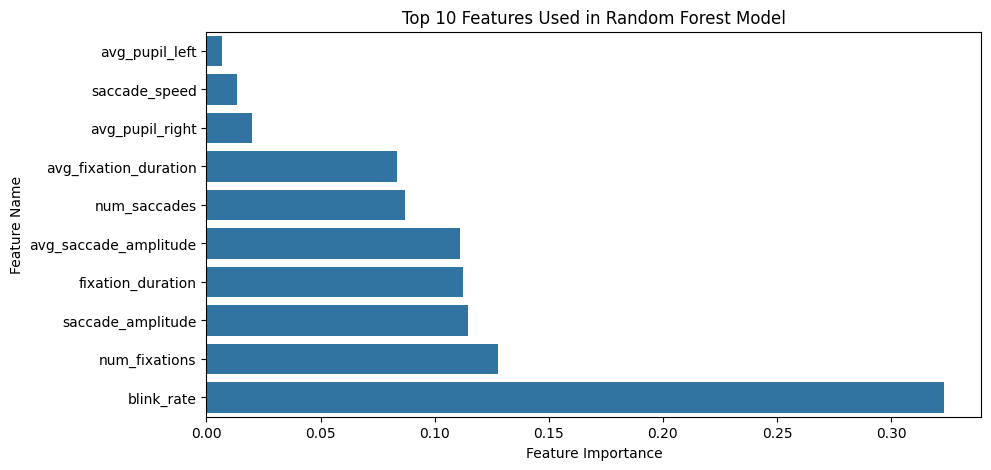

In [71]:
# Feature importance visualization
importances = rf.feature_importances_

# Get feature names from the original DataFrame (df)
feature_names = df.drop(columns=['label']).columns  # Assuming 'Label' is your target column

# Create a DataFrame to sort and plot feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the top features
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))  # Show top 10 features
plt.title("Top 10 Features Used in Random Forest Model")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

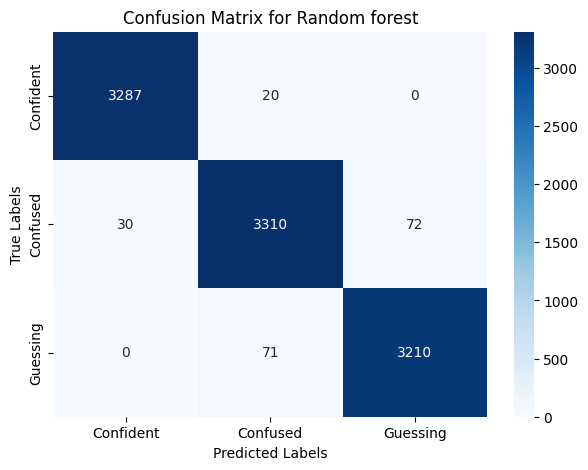

In [72]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix for Random forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

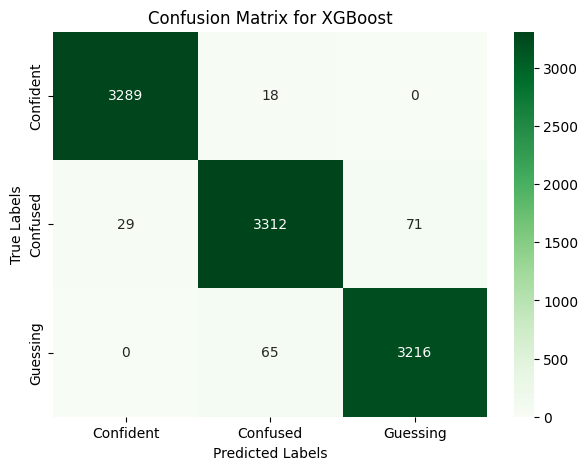

In [73]:
from sklearn.metrics import confusion_matrix

# First, create confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_decoded)

# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


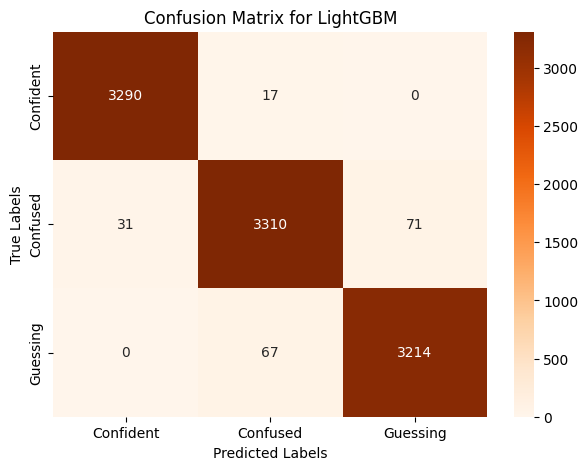

In [74]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgb)

# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Oranges", xticklabels=lgbm.classes_, yticklabels=lgbm.classes_)
plt.title("Confusion Matrix for LightGBM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


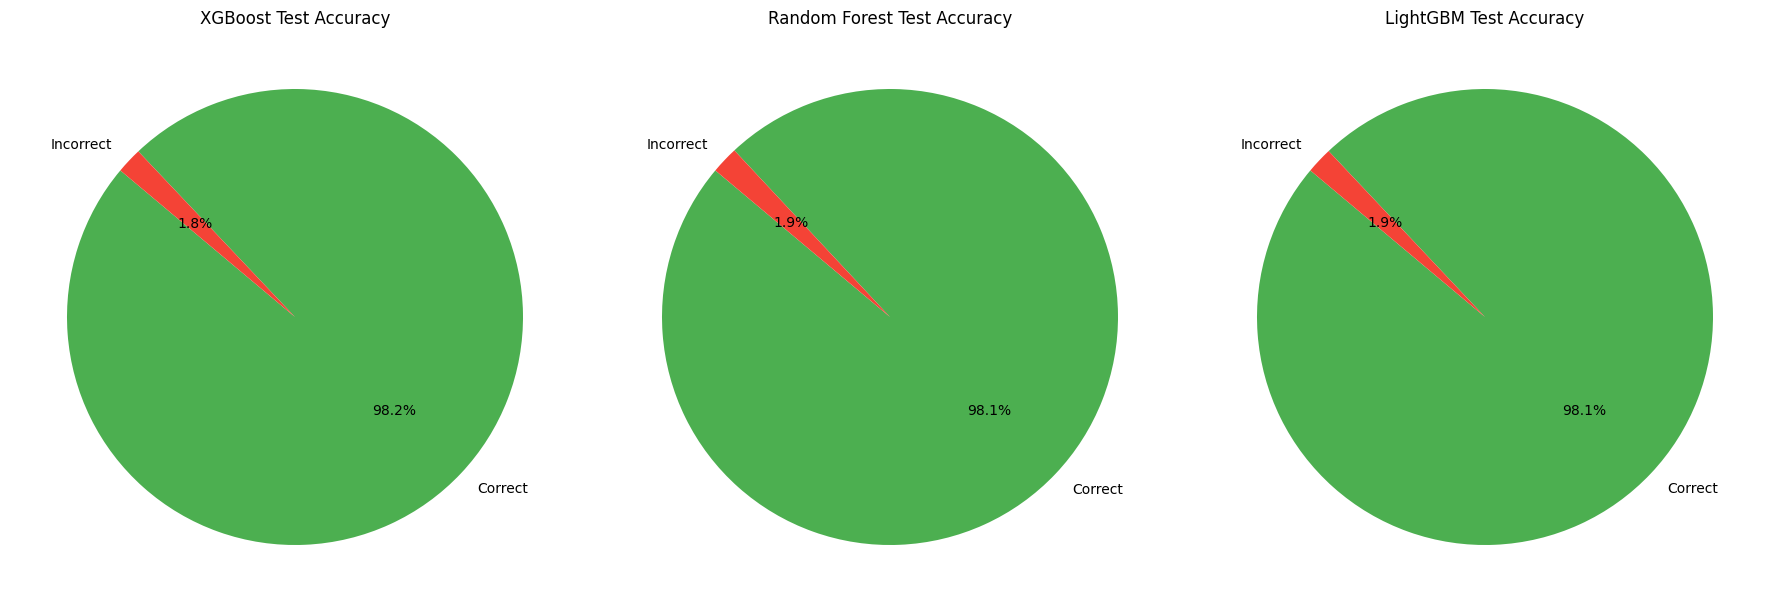

In [78]:
import matplotlib.pyplot as plt

# Data for each model
# XGBoost
correct_xgb = (y_test == y_pred_decoded).sum()
incorrect_xgb = (y_test != y_pred_decoded).sum()
sizes_xgb = [correct_xgb, incorrect_xgb]

# Random Forest
correct_rf = (y_test == y_test_pred).sum()
incorrect_rf = (y_test != y_test_pred).sum()
sizes_rf = [correct_rf, incorrect_rf]

# LightGBM
correct_lgbm = (y_test == y_pred_lgb).sum()
incorrect_lgbm = (y_test != y_pred_lgb).sum()
sizes_lgbm = [correct_lgbm, incorrect_lgbm]

labels = ['Correct', 'Incorrect']
colors = ['#4CAF50', '#F44336']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGBoost Pie Chart
axes[0].pie(sizes_xgb, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[0].set_title('XGBoost Test Accuracy')

# Random Forest Pie Chart
axes[1].pie(sizes_rf, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Random Forest Test Accuracy')

# LightGBM Pie Chart
axes[2].pie(sizes_lgbm, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
axes[2].set_title('LightGBM Test Accuracy')

# Make the layout neat
plt.tight_layout()
plt.show()


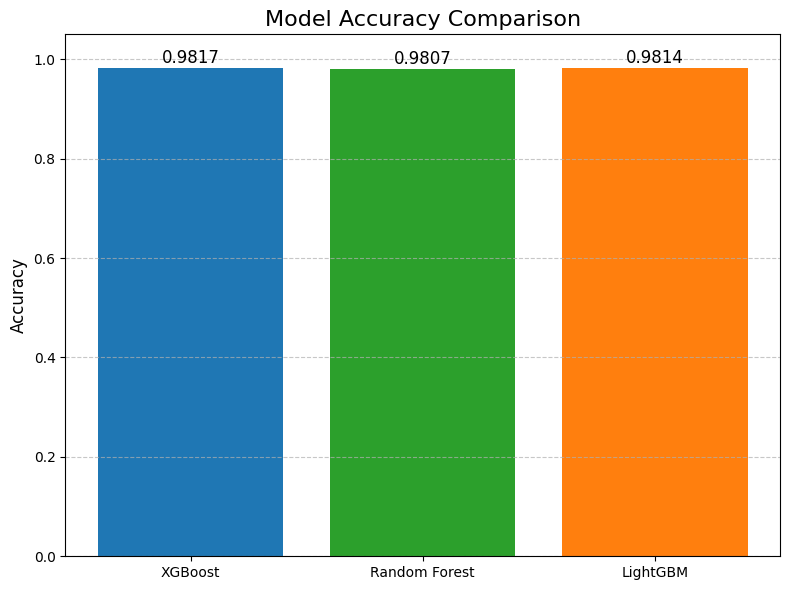

In [79]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy for each model
acc_xgb = accuracy_score(y_test, y_pred_decoded)
acc_rf = accuracy_score(y_test, y_test_pred)
acc_lgb = accuracy_score(y_test, y_pred_lgb)

# Data for bar chart
models = ['XGBoost', 'Random Forest', 'LightGBM']
accuracies = [acc_xgb, acc_rf, acc_lgb]
colors = ['#1f77b4', '#2ca02c', '#ff7f0e']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{acc:.4f}", ha='center', fontsize=12)

# Chart settings
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
